# **LLM 모델 양자화 비교**



---



**(코랩에서)한글 폰트 지정하는 방법**

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 코랩에서 위 코드를 실행시킨 후  반드시 코랩 메뉴: "런타임>세션 다시 시작" 합니다.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (19.1 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126675 files and direc

#### **라이브러리 설치**

In [ ]:
# ========================================
# 1. 필수 라이브러리 설치 및 로드
# ========================================
!pip install -q transformers accelerate bitsandbytes matplotlib pandas seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 31.6 MB/s eta 0:00:00


In [ ]:
# 라이브러리 설치전 설치된 버전 확인
import importlib.metadata
import sys

# 확인할 라이브러리 목록
libs_to_check = [
    "transformers",
    "accelerate",
    "bitsandbytes",
    "matplotlib",
    "pandas",
    "seaborn"
]

print(f"--- Python {sys.version.split()[0]} 환경 ---")
print("라이브러리 버전 확인:")
for lib in libs_to_check:
    try:
        print(f"✅ {lib}: {importlib.metadata.version(lib)}")
    except importlib.metadata.PackageNotFoundError:
        print(f"❌ {lib}: Not Installed")

print("-" * 30)

--- Python 3.12.12 환경 ---
라이브러리 버전 확인:
✅ transformers: 4.57.1
✅ accelerate: 1.10.1
✅ bitsandbytes: 0.48.1
✅ matplotlib: 3.10.0
✅ pandas: 2.2.2
✅ seaborn: 0.13.2
------------------------------




---



## **양자화 Quicktour**

- **양자화(Quantization)란?**
    - AI 모델의 가중치와 연산을 32비트/16비트에서 8비트/4비트 등 더 적은 비트로 표현하여 메모리 사용량을 줄이고 추론 속도를 높이는 모델 경량화 기술
    - **비유** : 고해상도 사진(32bit)을 압축된 저용량 이미지(4bit)로 변환하되, 육안으로는 거의 차이를 느낄 수 없도록 하는 것과 비슷

- **양자화 정밀도별 발전 과정**
|시기|양자화 기법|주요 연구/기술|특징|
|---|---|---|---|
| 2015-2017| INT8 양자화| Google TPU, TensorRT| 추론 가속화, 정수 연산 활용|
| 2018-2019| Mixed-Precision Training| NVIDIA Apex, PyTorch AMP| FP16+FP32 혼합 학습|
| 2020-2021| 8-bit Optimizers| Tim Dettmers (bitsandbytes)| 메모리 효율적 학습|
| 2022| LLM.int8()| Dettmers et al. 논문| 대형 언어 모델 8bit 추론|
| 2023| QLoRA, GPTQ, AWQ| 4bit 양자화 혁신| 파인튜닝 가능한 4bit 기법| 2024NF4, Double Quantization| QLoRA 개선| 더욱 정확한 4bit 표현|



- **비트별 양자화 특징 비교**

|항목|16-bit (FP16/BF16)|8-bit (INT8)|4-bit (NF4)|
|---|---|---|---|
|메모리 사용|-기준 (100%)|-약 50%|약 25%|
|정확도 손실|거의 없음|1-2%|2-5%|
|추론 속도|기준|1.5-2배 빠름|2-3배 빠름 (조건부)|
|구현 난이도|쉬움|보통|어려움|
|호환성|매우 높음|높음|제한적 (최신 GPU)|
|주요 용도|학습, 고품질 추론|프로덕션 배포|제한된 리소스 환경|


- **양자화 품질 지표**
|지표|설명|목표|
|---|---|---|
|Perplexity|언어 모델 성능|낮을수록 좋음|
|MMLU|멀티태스크 이해도|높을수록 좋음|
|HumanEval|코딩 능력|높을수록 좋음||메모리 압축률|원본 대비 크기|높을수록 좋음|

### **양자화 설정 예:**


- **16-bit** (FP16):

In [ ]:
import torch
torch_dtype=torch.float16  # 반정밀도 부동소수점

- **8-bit** (INT8 with LLM.int8()):

In [ ]:
from transformers import BitsAndBytesConfig

BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_threshold=6.0,        # Outlier 감지 임계값
    llm_int8_has_fp16_weight=False # 메모리 최적화
)

BitsAndBytesConfig {
  "_load_in_4bit": false,
  "_load_in_8bit": true,
  "bnb_4bit_compute_dtype": "float32",
  "bnb_4bit_quant_storage": "uint8",
  "bnb_4bit_quant_type": "fp4",
  "bnb_4bit_use_double_quant": false,
  "llm_int8_enable_fp32_cpu_offload": false,
  "llm_int8_has_fp16_weight": false,
  "llm_int8_skip_modules": null,
  "llm_int8_threshold": 6.0,
  "load_in_4bit": false,
  "load_in_8bit": true,
  "quant_method": "bitsandbytes"
}

- **4-bit** (NF4 with Double Quantization):

In [ ]:
BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",           # NormalFloat4 사용
    bnb_4bit_use_double_quant=True,      # 양자화 파라미터도 양자화
    bnb_4bit_compute_dtype=torch.float16 # 계산은 FP16
)

BitsAndBytesConfig {
  "_load_in_4bit": true,
  "_load_in_8bit": false,
  "bnb_4bit_compute_dtype": "float16",
  "bnb_4bit_quant_storage": "uint8",
  "bnb_4bit_quant_type": "nf4",
  "bnb_4bit_use_double_quant": true,
  "llm_int8_enable_fp32_cpu_offload": false,
  "llm_int8_has_fp16_weight": false,
  "llm_int8_skip_modules": null,
  "llm_int8_threshold": 6.0,
  "load_in_4bit": true,
  "load_in_8bit": false,
  "quant_method": "bitsandbytes"
}

### **예제: 양자화 코드**

- **테스트 모델** : **Qwen/Qwen2.5-7B-Instruct**
    - 출처: Alibaba Cloud (2024)
    - 벤치마크: 다국어 성능에서 최상위권 (MMLU, HumanEval 등에서 우수)
    - 한국어 지원: 자연스러운 한국어 생성 및 이해

In [ ]:
# ========================================
# Qwen2.5-7B-Instruct 16bit/8bit/4bit 양자화
# ========================================

# ========================================
# 1. 라이브러리 설치
# ========================================
# !pip install -q transformers accelerate bitsandbytes matplotlib pandas seaborn torch

import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig
)
import time
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from typing import Dict, List
import gc
import json


plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

print("✅ 라이브러리 설치 및 설정 완료")
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"총 VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")


✅ 라이브러리 설치 및 설정 완료
PyTorch 버전: 2.8.0+cu126
CUDA 사용 가능: True
GPU: NVIDIA A100-SXM4-40GB
총 VRAM: 39.56 GB


In [ ]:
# ========================================
# 2. 유틸리티 함수
# ========================================

def get_gpu_memory():
    """현재 GPU 메모리 사용량 (MB) 반환"""
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=memory.used', '--format=csv,nounits,noheader'],
            capture_output=True,
            text=True
        )
        return int(result.stdout.strip())
    except:
        return 0

def clear_memory():
    """GPU 메모리 완전 정리"""
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(1)

def get_model_size_mb(model):
    """모델의 실제 메모리 크기 계산 (MB)"""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_mb = (param_size + buffer_size) / 1024**2
    return size_mb

def count_parameters(model):
    """모델의 파라미터 수 계산"""
    return sum(p.numel() for p in model.parameters())

In [ ]:
# ========================================
# 3. 테스트 문장 준비
# ========================================

test_sentences = [
    # 한국어
    "인공지능 기술의 발전이 우리 사회에 미치는 영향을 설명해주세요.",
    "양자화 기법을 사용하면 대형 언어 모델의 효율성을 높일 수 있습니다.",

    # 일본어
    "人工知能技術の発展が私たちの社会に与える影響を説明してください。",

    # 영어
    "Explain the impact of artificial intelligence on modern society.",

    # 수학 문제
    "123 곱하기 456은 얼마인가요? 단계별로 계산해주세요."
]

print("\n" + "="*70)
print("📝 테스트 문장 준비 완료")
print("="*70)
for i, sent in enumerate(test_sentences, 1):
    print(f"{i}. {sent}")


📝 테스트 문장 준비 완료
1. 인공지능 기술의 발전이 우리 사회에 미치는 영향을 설명해주세요.
2. 양자화 기법을 사용하면 대형 언어 모델의 효율성을 높일 수 있습니다.
3. 人工知能技術の発展が私たちの社会に与える影響を説明してください。
4. Explain the impact of artificial intelligence on modern society.
5. 123 곱하기 456은 얼마인가요? 단계별로 계산해주세요.


In [ ]:
# ========================================
# 4. 모델 설정 클래스
# ========================================

class QuantizationConfig:
    """양자화 설정을 위한 클래스"""

    @staticmethod
    def get_fp16_config():
        """16-bit (FP16) 설정"""
        return {
            'name': '16-bit (FP16)',
            'torch_dtype': torch.float16,
            'load_in_8bit': False,
            'load_in_4bit': False,
            'quantization_config': None
        }

    @staticmethod
    def get_bf16_config():
        """16-bit (BF16) 설정 - Ampere GPU 이상 필요"""
        return {
            'name': '16-bit (BF16)',
            'torch_dtype': torch.bfloat16,
            'load_in_8bit': False,
            'load_in_4bit': False,
            'quantization_config': None
        }

    @staticmethod
    def get_8bit_config():
        """8-bit 양자화 설정 (LLM.int8())"""
        bnb_config = BitsAndBytesConfig(
            load_in_8bit=True,
            llm_int8_threshold=6.0,  # Outlier 임계값
            llm_int8_has_fp16_weight=False  # 메모리 절약
        )
        return {
            'name': '8-bit (INT8)',
            'torch_dtype': None,
            'load_in_8bit': True,
            'load_in_4bit': False,
            'quantization_config': bnb_config
        }

    @staticmethod
    def get_4bit_config():
        """4-bit 양자화 설정 (NF4 + Double Quantization)"""
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",  # NormalFloat4
            bnb_4bit_use_double_quant=True,  # Double Quantization
            bnb_4bit_compute_dtype=torch.float16  # 계산은 FP16으로
        )
        return {
            'name': '4-bit (NF4)',
            'torch_dtype': None,
            'load_in_8bit': False,
            'load_in_4bit': True,
            'quantization_config': bnb_config
        }


In [ ]:
# ========================================
# 5. 모델 로드 및 벤치마크 함수
# ========================================

def load_and_benchmark(model_name: str, config: Dict, test_sentences: List[str]) -> Dict:
    """
    모델을 특정 양자화 설정으로 로드하고 벤치마크 수행

    Args:
        model_name: Hugging Face 모델 ID
        config: 양자화 설정 딕셔너리
        test_sentences: 테스트 문장 리스트

    Returns:
        벤치마크 결과 딕셔너리
    """

    print("\n" + "="*70)
    print(f"🔧 {config['name']} 모델 로드 중...")
    print("="*70)

    clear_memory()
    initial_memory = get_gpu_memory()

    # 토크나이저 로드
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

    # 모델 로드 시작 시간
    load_start = time.time()

    try:
        # 양자화 설정에 따라 모델 로드
        if config['quantization_config'] is not None:
            model = AutoModelForCausalLM.from_pretrained(
                model_name,
                quantization_config=config['quantization_config'],
                device_map="auto",
                trust_remote_code=True
            )
        else:
            model = AutoModelForCausalLM.from_pretrained(
                model_name,
                torch_dtype=config['torch_dtype'],
                device_map="auto",
                trust_remote_code=True
            )

        load_time = time.time() - load_start

        # 모델 정보 수출
        param_count = count_parameters(model)
        model_size_mb = get_model_size_mb(model)

        print(f"✅ 모델 로드 완료 ({load_time:.2f}초)")
        print(f"   파라미터 수: {param_count:,}")
        print(f"   모델 크기: {model_size_mb:.2f} MB ({model_size_mb/1024:.2f} GB)")

    except Exception as e:
        print(f"❌ 모델 로드 실패: {str(e)}")
        return None

    # 메모리 측정
    torch.cuda.synchronize()
    loaded_memory = get_gpu_memory()
    memory_used_mb = loaded_memory - initial_memory

    print(f"   VRAM 사용량: {memory_used_mb} MB ({memory_used_mb/1024:.2f} GB)")

    # 추론 벤치마크
    model.eval()
    inference_results = []

    print(f"\n🚀 추론 벤치마크 시작 ({len(test_sentences)}개 문장)...")

    for idx, sentence in enumerate(test_sentences, 1):
        # 토큰화
        inputs = tokenizer(sentence, return_tensors="pt").to(model.device)
        input_length = inputs.input_ids.shape[1]

        # Warm-up
        with torch.no_grad():
            _ = model.generate(
                **inputs,
                max_new_tokens=50,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )

        torch.cuda.synchronize()

        # 실제 측정 (3회 반복)
        times = []
        for run in range(3):
            start_time = time.time()

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=50,
                    do_sample=False,
                    pad_token_id=tokenizer.eos_token_id
                )

            torch.cuda.synchronize()
            times.append(time.time() - start_time)

        avg_time = np.mean(times)
        generated_length = outputs.shape[1] - input_length
        tokens_per_sec = generated_length / avg_time

        # 생성된 텍스트
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        inference_results.append({
            'sentence_id': idx,
            'input': sentence,
            'output': generated_text,
            'tokens_generated': generated_length,
            'time_sec': avg_time,
            'tokens_per_sec': tokens_per_sec
        })

        print(f"   문장 {idx}: {tokens_per_sec:.2f} tokens/sec ({avg_time:.3f}s)")

    # 평균 계산
    avg_tokens_per_sec = np.mean([r['tokens_per_sec'] for r in inference_results])
    avg_time = np.mean([r['time_sec'] for r in inference_results])

    # 결과 반환
    result = {
        'quantization': config['name'],
        'load_time_sec': load_time,
        'param_count': param_count,
        'model_size_mb': model_size_mb,
        'memory_used_mb': memory_used_mb,
        'memory_used_gb': memory_used_mb / 1024,
        'avg_tokens_per_sec': avg_tokens_per_sec,
        'avg_time_sec': avg_time,
        'inference_results': inference_results
    }

    # 메모리 해제
    del model
    del tokenizer
    clear_memory()

    print(f"\n✅ {config['name']} 벤치마크 완료!")
    print(f"   평균 속도: {avg_tokens_per_sec:.2f} tokens/sec")
    print(f"   메모리 사용: {memory_used_mb/1024:.2f} GB")

    return result

In [ ]:
# ========================================
# 6. 메인 실행 - 3가지 양자화 비교
# ========================================

model_name = "Qwen/Qwen2.5-7B-Instruct"

print("\n" + "="*70)
print("🎯 Qwen2.5-7B-Instruct 양자화 벤치마크")
print("="*70)
print(f"모델: {model_name}")
print(f"양자화 타입: 16-bit (FP16), 8-bit (INT8), 4-bit (NF4)")
print("="*70)

# GPU 확인
if not torch.cuda.is_available():
    print("❌ GPU를 사용할 수 없습니다. CPU 모드는 매우 느립니다.")
else:
    print(f"✅ GPU 사용 가능: {torch.cuda.get_device_name(0)}")

# 양자화 설정 목록
configs = [
    QuantizationConfig.get_fp16_config(),   # 16-bit
    QuantizationConfig.get_8bit_config(),   # 8-bit
    QuantizationConfig.get_4bit_config()    # 4-bit
]

# BF16도 테스트 (Ampere GPU 이상에서만)
if torch.cuda.is_available():
    compute_capability = torch.cuda.get_device_capability()
    if compute_capability[0] >= 8:  # Ampere (A100, RTX 3090 등)
        print("✅ BF16 지원 GPU 감지 - BF16도 테스트합니다.")
        # configs.insert(1, QuantizationConfig.get_bf16_config())

# 전체 결과 저장
all_results = []

# 각 양자화 설정으로 벤치마크
for config in configs:
    result = load_and_benchmark(model_name, config, test_sentences)
    if result is not None:
        all_results.append(result)

    # 모델 간 충분한 대기 시간
    time.sleep(2)



🎯 Qwen2.5-7B-Instruct 양자화 벤치마크
모델: Qwen/Qwen2.5-7B-Instruct
양자화 타입: 16-bit (FP16), 8-bit (INT8), 4-bit (NF4)
✅ GPU 사용 가능: NVIDIA A100-SXM4-40GB
✅ BF16 지원 GPU 감지 - BF16도 테스트합니다.

🔧 16-bit (FP16) 모델 로드 중...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ 모델 로드 완료 (93.82초)
   파라미터 수: 7,615,616,512
   모델 크기: 14525.64 MB (14.19 GB)
   VRAM 사용량: 14734 MB (14.39 GB)

🚀 추론 벤치마크 시작 (5개 문장)...
   문장 1: 31.01 tokens/sec (1.612s)
   문장 2: 30.97 tokens/sec (1.614s)
   문장 3: 30.97 tokens/sec (1.614s)
   문장 4: 30.92 tokens/sec (1.617s)
   문장 5: 31.09 tokens/sec (1.608s)

✅ 16-bit (FP16) 벤치마크 완료!
   평균 속도: 30.99 tokens/sec
   메모리 사용: 14.39 GB

🔧 8-bit (INT8) 모델 로드 중...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✅ 모델 로드 완료 (21.95초)
   파라미터 수: 7,615,616,512
   모델 크기: 8302.64 MB (8.11 GB)
   VRAM 사용량: 6 MB (0.01 GB)

🚀 추론 벤치마크 시작 (5개 문장)...
   문장 1: 6.32 tokens/sec (7.914s)
   문장 2: 6.31 tokens/sec (7.928s)
   문장 3: 6.45 tokens/sec (7.750s)
   문장 4: 6.42 tokens/sec (7.787s)
   문장 5: 6.52 tokens/sec (7.673s)

✅ 8-bit (INT8) 벤치마크 완료!
   평균 속도: 6.40 tokens/sec
   메모리 사용: 0.01 GB

🔧 4-bit (NF4) 모델 로드 중...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✅ 모델 로드 완료 (12.82초)
   파라미터 수: 4,352,972,288
   모델 크기: 5191.14 MB (5.07 GB)
   VRAM 사용량: 66 MB (0.06 GB)

🚀 추론 벤치마크 시작 (5개 문장)...
   문장 1: 15.79 tokens/sec (3.167s)
   문장 2: 15.65 tokens/sec (3.195s)
   문장 3: 15.67 tokens/sec (3.191s)
   문장 4: 15.77 tokens/sec (3.170s)
   문장 5: 15.86 tokens/sec (3.152s)

✅ 4-bit (NF4) 벤치마크 완료!
   평균 속도: 15.75 tokens/sec
   메모리 사용: 0.06 GB



📊 결과 분석 및 시각화

📋 종합 비교표:
          양자화  로드 시간 (초)  모델 크기 (GB)  VRAM (GB)  평균 속도 (tok/s)  평균 지연 (초)
16-bit (FP16)      93.82       14.19      14.39          30.99      1.613
 8-bit (INT8)      21.95        8.11       0.01           6.40      7.811
  4-bit (NF4)      12.82        5.07       0.06          15.75      3.175

📈 16-bit 대비 개선율:

  【 8-bit (INT8) 】
    메모리 절감: 100.0%
    속도 변화: -79.3%

  【 4-bit (NF4) 】
    메모리 절감: 99.6%
    속도 변화: -49.2%


/tmp/ipython-input-3230134509.py:164: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) NanumGothic.
  plt.savefig('qwen_quantization_analysis.png', dpi=300, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


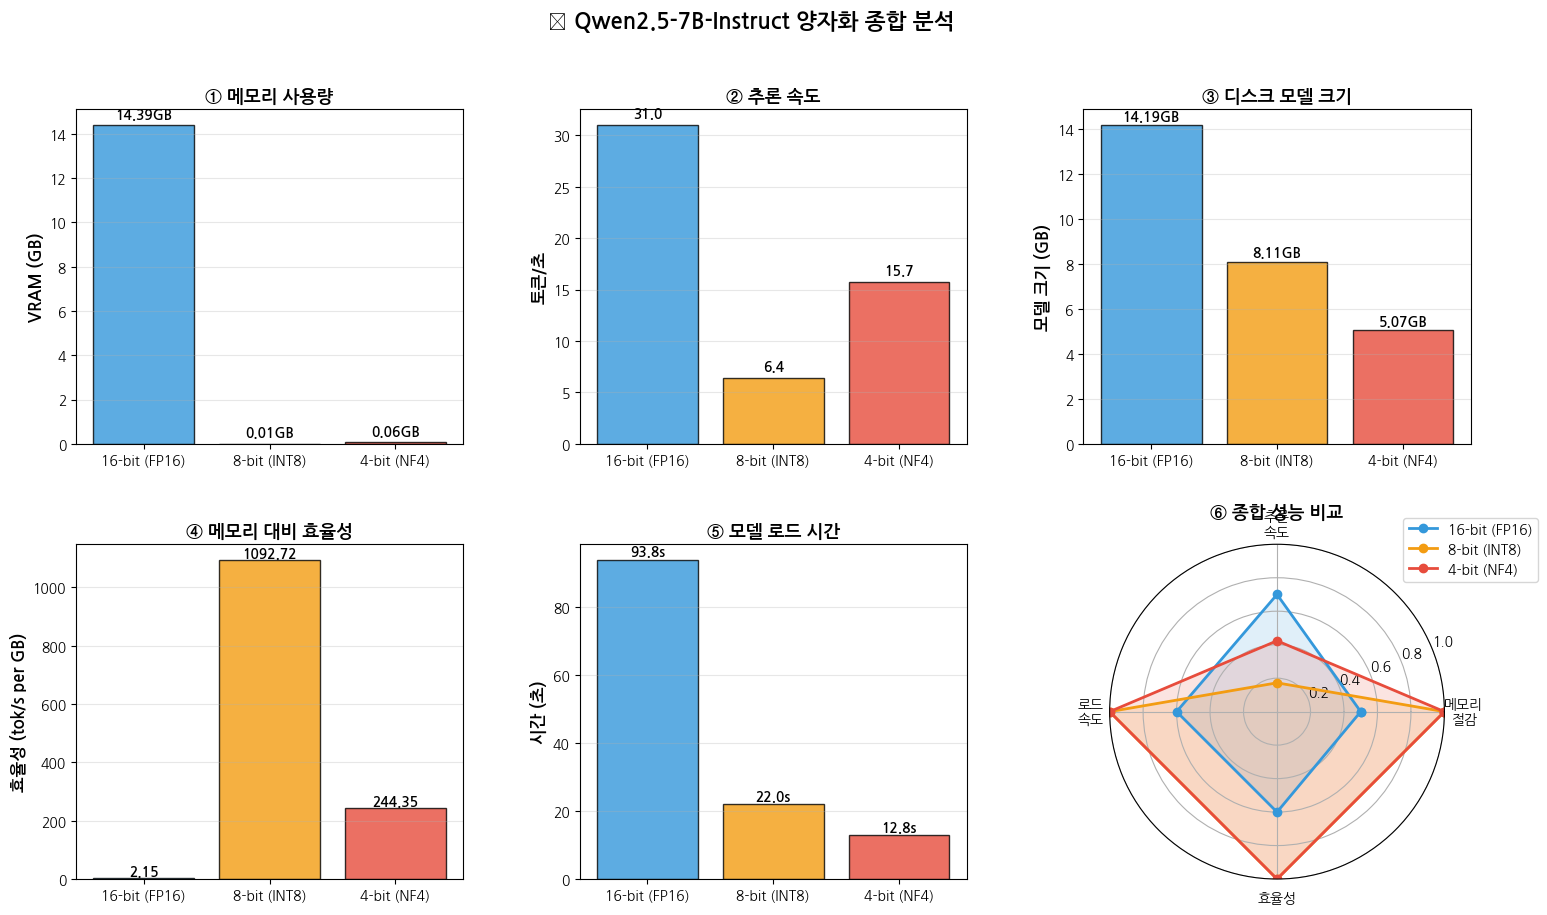


✅ 시각화 완료! 저장된 파일: qwen_quantization_analysis.png

📝 생성 예시 비교 (첫 번째 테스트 문장)

【 16-bit (FP16) 】
입력: 인공지능 기술의 발전이 우리 사회에 미치는 영향을 설명해주세요....
출력: 인공지능 기술의 발전이 우리 사회에 미치는 영향을 설명해주세요. 인공지능 기술의 발전은 우리 사회에 다양한 영향을 미치고 있습니다. 

1. 산업 혁신: 인공지능은 제조, 금융, 의료 등 다양한 산...
속도: 31.01 tok/s

【 8-bit (INT8) 】
입력: 인공지능 기술의 발전이 우리 사회에 미치는 영향을 설명해주세요....
출력: 인공지능 기술의 발전이 우리 사회에 미치는 영향을 설명해주세요. 인공지능(AI) 기술의 발전은 우리 사회에 다양한 영향을 미치고 있습니다. 주요 영향들을 다음과 같이 요약할 수 있습니다.

1. 산업 구조 변화: AI 기술...
속도: 6.32 tok/s

【 4-bit (NF4) 】
입력: 인공지능 기술의 발전이 우리 사회에 미치는 영향을 설명해주세요....
출력: 인공지능 기술의 발전이 우리 사회에 미치는 영향을 설명해주세요. 인공지능 기술의 발전은 우리 사회에 다양한 영향을 미치고 있습니다. 

첫째, 생산성 향상: 인공지능은 자동화와 효율성을 통해 생산성을 크게 �...
속도: 15.79 tok/s

✅ 전체 벤치마크 완료!


In [ ]:
# ========================================
# 7. 결과 분석 및 시각화
# ========================================

if len(all_results) == 0:
    print("\n❌ 벤치마크 결과가 없습니다.")
else:
    print("\n" + "="*70)
    print("📊 결과 분석 및 시각화")
    print("="*70)

    # DataFrame 생성
    summary_data = []
    for result in all_results:
        summary_data.append({
            '양자화': result['quantization'],
            '로드 시간 (초)': round(result['load_time_sec'], 2),
            '모델 크기 (GB)': round(result['model_size_mb'] / 1024, 2),
            'VRAM (GB)': round(result['memory_used_gb'], 2),
            '평균 속도 (tok/s)': round(result['avg_tokens_per_sec'], 2),
            '평균 지연 (초)': round(result['avg_time_sec'], 3)
        })

    df = pd.DataFrame(summary_data)

    print("\n📋 종합 비교표:")
    print(df.to_string(index=False))

    # 개선율 계산 (16-bit 기준)
    if len(all_results) >= 2:
        fp16_memory = all_results[0]['memory_used_gb']
        fp16_speed = all_results[0]['avg_tokens_per_sec']

        print("\n📈 16-bit 대비 개선율:")
        for i, result in enumerate(all_results):
            if i == 0:
                continue

            memory_reduction = (1 - result['memory_used_gb'] / fp16_memory) * 100
            speed_change = ((result['avg_tokens_per_sec'] / fp16_speed) - 1) * 100

            print(f"\n  【 {result['quantization']} 】")
            print(f"    메모리 절감: {memory_reduction:.1f}%")
            print(f"    속도 변화: {speed_change:+.1f}%")

    # ========================================
    # 시각화 - 5개 그래프
    # ========================================

    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

    quantizations = [r['quantization'] for r in all_results]
    colors = ['#3498db', '#f39c12', '#e74c3c'][:len(all_results)]

    # 그래프 1: 메모리 사용량
    ax1 = fig.add_subplot(gs[0, 0])
    memory_values = [r['memory_used_gb'] for r in all_results]
    bars1 = ax1.bar(quantizations, memory_values, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_ylabel('VRAM (GB)', fontsize=12, fontweight='bold')
    ax1.set_title('① 메모리 사용량', fontsize=13, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)

    for bar, val in zip(bars1, memory_values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.2,
                f'{val:.2f}GB', ha='center', va='bottom', fontsize=10, fontweight='bold')


    # 그래프 2: 추론 속도
    ax2 = fig.add_subplot(gs[0, 1])
    speed_values = [r['avg_tokens_per_sec'] for r in all_results]
    bars2 = ax2.bar(quantizations, speed_values, color=colors, alpha=0.8, edgecolor='black')
    ax2.set_ylabel('토큰/초', fontsize=12, fontweight='bold')
    ax2.set_title('② 추론 속도', fontsize=13, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)

    for bar, val in zip(bars2, speed_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{val:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')


    # 그래프 3: 모델 크기
    ax3 = fig.add_subplot(gs[0, 2])
    size_values = [r['model_size_mb'] / 1024 for r in all_results]
    bars3 = ax3.bar(quantizations, size_values, color=colors, alpha=0.8, edgecolor='black')
    ax3.set_ylabel('모델 크기 (GB)', fontsize=12, fontweight='bold')
    ax3.set_title('③ 디스크 모델 크기', fontsize=13, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)

    for bar, val in zip(bars3, size_values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{val:.2f}GB', ha='center', va='bottom', fontsize=10, fontweight='bold')


    # 그래프 4: 효율성 비교 (속도/메모리)
    ax4 = fig.add_subplot(gs[1, 0])
    efficiency = [s/m for s, m in zip(speed_values, memory_values)]
    bars4 = ax4.bar(quantizations, efficiency, color=colors, alpha=0.8, edgecolor='black')
    ax4.set_ylabel('효율성 (tok/s per GB)', fontsize=12, fontweight='bold')
    ax4.set_title('④ 메모리 대비 효율성', fontsize=13, fontweight='bold')
    ax4.grid(axis='y', alpha=0.3)

    for bar, val in zip(bars4, efficiency):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')


    # 그래프 5: 로드 시간
    ax5 = fig.add_subplot(gs[1, 1])
    load_times = [r['load_time_sec'] for r in all_results]
    bars5 = ax5.bar(quantizations, load_times, color=colors, alpha=0.8, edgecolor='black')
    ax5.set_ylabel('시간 (초)', fontsize=12, fontweight='bold')
    ax5.set_title('⑤ 모델 로드 시간', fontsize=13, fontweight='bold')
    ax5.grid(axis='y', alpha=0.3)

    for bar, val in zip(bars5, load_times):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{val:.1f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')


    # 그래프 6: 종합 레이더 차트
    ax6 = fig.add_subplot(gs[1, 2], projection='polar')


    # 정규화 (0-1 범위로)
    categories = ['메모리\n절감', '추론\n속도', '로드\n속도', '효율성']

    # 16-bit를 기준으로 정규화
    if len(all_results) >= 2:
        for i, result in enumerate(all_results):
            if i == 0:
                # 16-bit는 기준값 (0.7 정도)
                values = [0.5, 0.7, 0.6, 0.6]
            else:
                mem_score = min(1.0, (fp16_memory / result['memory_used_gb']) / 4)  # 4배 절감이 최고
                speed_score = min(1.0, result['avg_tokens_per_sec'] / (fp16_speed * 1.2))
                load_score = min(1.0, all_results[0]['load_time_sec'] / result['load_time_sec'])
                eff_score = min(1.0, (result['avg_tokens_per_sec'] / result['memory_used_gb']) /
                               (fp16_speed / fp16_memory) / 1.5)
                values = [mem_score, speed_score, load_score, eff_score]

            angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
            values += values[:1]
            angles += angles[:1]

            ax6.plot(angles, values, 'o-', linewidth=2, label=result['quantization'], color=colors[i])
            ax6.fill(angles, values, alpha=0.15, color=colors[i])

        ax6.set_xticks(angles[:-1])
        ax6.set_xticklabels(categories, fontsize=10)
        ax6.set_ylim(0, 1)
        ax6.set_title('⑥ 종합 성능 비교', fontsize=13, fontweight='bold', pad=20)
        ax6.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
        ax6.grid(True)

    plt.suptitle('🔬 Qwen2.5-7B-Instruct 양자화 종합 분석',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.savefig('qwen_quantization_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✅ 시각화 완료! 저장된 파일: qwen_quantization_analysis.png")


# ========================================
# 8. 생성 예시 출력
# ========================================

print("\n" + "="*70)
print("📝 생성 예시 비교 (첫 번째 테스트 문장)")
print("="*70)

for result in all_results:
    print(f"\n【 {result['quantization']} 】")
    if len(result['inference_results']) > 0:
        first_result = result['inference_results'][0]
        print(f"입력: {first_result['input'][:60]}...")
        print(f"출력: {first_result['output'][:200]}...")
        print(f"속도: {first_result['tokens_per_sec']:.2f} tok/s")

print("\n" + "="*70)
print("✅ 전체 벤치마크 완료!")
print("="*70)

In [ ]:
all_results

# print("\n" + "="*70)
# print("📝 생성 예시 비교 (전체)")
# print("="*70)

for result in all_results:
    print(f"\n【 {result['quantization']} 】")
    if len(result['inference_results']) > 0:
        for first_result in result['inference_results']:
            print(f"✅ sentence_id : {first_result['sentence_id']}")
            print(f"입력: {first_result['input'][:60]}...")
            print(f"출력: {first_result['output'][:200]}...")
            print(f"속도: {first_result['tokens_per_sec']:.2f} tok/s")
            print()



【 16-bit (FP16) 】
✅ sentence_id : 1
입력: 인공지능 기술의 발전이 우리 사회에 미치는 영향을 설명해주세요....
출력: 인공지능 기술의 발전이 우리 사회에 미치는 영향을 설명해주세요. 인공지능 기술의 발전은 우리 사회에 다양한 영향을 미치고 있습니다. 

1. 산업 혁신: 인공지능은 제조, 금융, 의료 등 다양한 산...
속도: 31.01 tok/s

✅ sentence_id : 2
입력: 양자화 기법을 사용하면 대형 언어 모델의 효율성을 높일 수 있습니다....
출력: 양자화 기법을 사용하면 대형 언어 모델의 효율성을 높일 수 있습니다. 이 기법은 모델의 가중치를 더 작은 값으로 압축하여 메모리 사용량을 줄이고, 계산 비용을 줄일 수 있습니다. 또한 양자화는 모델의 정...
속도: 30.97 tok/s

✅ sentence_id : 3
입력: 人工知能技術の発展が私たちの社会に与える影響を説明してください。...
출력: 人工知能技術の発展が私たちの社会に与える影響を説明してください。 人工知能（AI）技術の発展は、私たちの社会に多大な影響を及ぼしています。以下にその主な影響をいくつか挙げます。

1. 生産性の向上：AIは...
속도: 30.97 tok/s

✅ sentence_id : 4
입력: Explain the impact of artificial intelligence on modern soci...
출력: Explain the impact of artificial intelligence on modern society. Artificial intelligence (AI) has had a significant impact on modern society, transforming various aspects of our lives and the way we i...
속도: 30.92 tok/s

✅ sentence_id : 5
입력: 123 곱하기 456은 얼마인가요? 단계별로 계산해주세요....
출력: 123 곱하기 456은 얼마인가요? 단계별로



---



## **LLM 모델 양자화 비교**

###  **비교할 LLM 모델(3개)**
- **한국어 지원 모델 선정**

|모델명|크기|특징|Colab T4 실행|Colab A100 실행|
|---|---|---|---|---|
|**Qwen/Qwen2.5-7B-Instruct**| 7B| 다국어 최강, 한국어 우수| 4-bit 가능| FP16/4-bit 모두 가능|
|**meta-llama/Meta-Llama-3.1-8B-Instruct**| 8B| Meta의 최신 모델, 다국어 지원| 4-bit 가능| FP16/4-bit 모두 가능beomi/|
|**Llama-3-Open-Ko-8B-Instruct**| 8B| 한국어 특화 파인튜닝| 4-bit 가능| FP16/4-bit 모두 가능|

- **선정이유**
    - **Qwen/Qwen2.5-7B-Instruct**
        - 출처: Alibaba Cloud (2024)
        - 벤치마크: 다국어 성능에서 최상위권 (MMLU, HumanEval 등에서 우수)
        - 한국어 지원: 자연스러운 한국어 생성 및 이해
    - **meta-llama/Meta-Llama-3.1-8B-Instruct**
        - 출처: Meta AI (2024)
        - 벤치마크: Llama 3.1 시리즈, instruction following 우수
        - 참고 : https://ai.meta.com/blog/meta-llama-3-1/
        - https://github.com/meta-llama/llama-cookbook
    - **Llama-3-Open-Ko-8B-Instruct**
        - 출처: Beomi (한국 개발자)
        - 특징: Llama-3를 한국어 데이터셋으로 추가 학습
        - 참고 : https://github.com/beomi/Llama-3-Open-Ko

- **VRAM 사용량 측정** : get_gpu_memory()
- **추론 속도 측정** : 모델이 입력(prompt)을 받아서 출력을 만들어내는 데 걸리는 시간


- **추론 속도에 영향을 주는 요인**

|요인|	설명|	예시|
|---|---|---|
|모델 크기(파라미터 수)|	모델이 클수록 연산이 많아 느림|	7B < 13B < 70B|
|하드웨어(GPU)	|GPU의 코어 수·메모리·대역폭이 클수록 빠름|	T4 < A100 < H100|
|양자화(Quantization)|	16bit → 4bit로 압축하면 속도 ↑, 정확도 ↓	|QLoRA 등|
|Batch Size|	한 번에 여러 입력 처리 시 전체 효율 ↑, 지연시간은 ↑	|예: batch=8|
|컨텍스트 길이|	입력 문장 길이가 길면 느려짐|	512토큰보다 4096토큰이 느림|
|Flash Attention 등 최적화|	최신 커널 사용 시 속도 크게 향상|FlashAttention2, vLLM 등|


### **예제 : 추론 속도 측정**


In [ ]:
import time
from transformers import AutoTokenizer, AutoModelForCausalLM

print('\n✅ 모델 & 토크나이저 다운로드')
model_name = "Qwen/Qwen2.5-7B-Instruct"  # 예시 모델
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")

prompt = "한국의 인공지능 산업 전망을 3줄로 요약해줘."

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

print('\n✅ 텍스트 생성(시간 측정)')
# --- 측정 시작 ---
start = time.time()
outputs = model.generate(**inputs, max_new_tokens=50)
end = time.time()
# --- 측정 끝 ---

print('\n✅ 텍스트 생성 결과')
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f'generated_text=\n{generated_text}')

elapsed = end - start
num_tokens = outputs.shape[-1] - inputs['input_ids'].shape[-1]
print(f"\n⏱️ 총 걸린 시간: {elapsed:.2f}초")
print(f"📦 생성된 토큰 수: {num_tokens}")
print(f"⚡ 초당 속도: {num_tokens/elapsed:.2f} tokens/sec")



✅ 모델 & 토크나이저 다운로드


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


✅ 텍스트 생성(시간 측정)

✅ 텍스트 생성 결과
generated_text=
한국의 인공지능 산업 전망을 3줄로 요약해줘. 한국은 인공지능 분야에서 세계적으로 경쟁력을 갖추고 있으며, 정부의 지원과 민간 기업들의 투자가 활발하여 빠르게 성장하고 있다. 또한, 

⏱️ 총 걸린 시간: 2.14초
📦 생성된 토큰 수: 50
⚡ 초당 속도: 23.33 tokens/sec


###**예제: 3개 모델 양자화 비교 코드**

#### **모델 사용 허가 받기**
- Hugging face Llama-3.1-8B 모델 Gated Repo 허가 받기
- https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct

In [ ]:
# 모델 사용 허가받기
from huggingface_hub import notebook_login

# 이 셀을 실행하면 토큰(token)을 입력하라는 창이 뜹니다.
# Hugging Face (https://huggingface.co/settings/tokens)에서
# 'read' 권한이 있는 토큰을 발급받아 복사/붙여넣기 하세요.
notebook_login()

#### **코드 실행**

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import time
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from typing import List, Dict
import gc

In [ ]:
# ========================================
# 2. VRAM 사용량 측정 함수
# ========================================
def get_gpu_memory():
    """nvidia-smi를 사용하여 현재 VRAM 사용량(MB) 반환"""
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=memory.used', '--format=csv,nounits,noheader'],
            capture_output=True,
            text=True
        )
        return int(result.stdout.strip())
    except:
        return 0

def clear_memory():
    """GPU 메모리 완전 정리"""
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)  # 메모리 해제 대기


# ========================================
# 3. 추론 속도 및 메모리 측정 함수
# ========================================
def benchmark_model(model, tokenizer, test_sentences: List[str],
                   model_name: str, quantization: str) -> Dict:
    """
    모델의 추론 속도와 메모리 사용량을 측정

    Args:
        model: 로드된 모델
        tokenizer: 토크나이저
        test_sentences: 테스트 문장 리스트
        model_name: 모델 이름
        quantization: 양자화 타입 (FP16, 4-bit)

    Returns:
        dict: 측정 결과
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()

    # 초기 메모리 측정
    clear_memory()
    initial_memory = get_gpu_memory()

    results = []

    print(f"\n[{model_name} - {quantization}] 벤치마크 시작...")

    for idx, sentence in enumerate(test_sentences, 1):
        # 토큰화
        inputs = tokenizer(sentence, return_tensors="pt").to(device)
        input_length = inputs.input_ids.shape[1]

        # Warm-up
        with torch.no_grad():
            _ = model.generate(
                **inputs,
                max_new_tokens=50,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )

        torch.cuda.synchronize()

        # 실제 측정 (3회 반복 후 평균)
        times = []
        for _ in range(3):
            start_time = time.time()

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=50,
                    do_sample=False,
                    pad_token_id=tokenizer.eos_token_id
                )

            torch.cuda.synchronize()
            times.append(time.time() - start_time)

        elapsed_time = np.mean(times)

        # 생성된 토큰 수 계산
        generated_length = outputs.shape[1] - input_length
        tokens_per_second = generated_length / elapsed_time if elapsed_time > 0 else 0

        # 생성된 텍스트
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        results.append({
            'sentence_id': idx,
            'input': sentence[:50] + "...",  # 표시용으로 축약
            'generated_tokens': generated_length,
            'time_sec': elapsed_time,
            'tokens_per_sec': tokens_per_second
        })

        print(f"  문장 {idx}: {tokens_per_second:.2f} tokens/sec")

    # 최종 메모리 측정
    torch.cuda.synchronize()
    final_memory = get_gpu_memory()
    memory_used = max(0, final_memory - initial_memory)

    # 평균 계산
    avg_tokens_per_sec = np.mean([r['tokens_per_sec'] for r in results])

    return {
        'model_name': model_name,
        'quantization': quantization,
        'results': results,
        'avg_tokens_per_sec': avg_tokens_per_sec,
        'memory_mb': memory_used,
        'memory_gb': memory_used / 1024
    }


In [ ]:
# ========================================
# 4. 테스트 문장 준비
# ========================================
test_sentences = [
    # 한국어
    "인공지능은 현대 사회에서 매우 중요한 기술입니다.",
    "양자화 기법을 사용하면 모델의 크기를 줄일 수 있습니다.",
    "대형 언어 모델의 추론 속도를 향상시키는 방법은 무엇인가요?",

    # 일본어
    "人工知能は現代社会で非常に重要な技術です。",
    "量子化技術を使用すると、モデルのサイズを削減できます。",
    "大規模言語モデルの推論速度を向上させる方法は何ですか？",

    # English
    "Artificial intelligence is a very important technology in modern society.",
    "Using quantization techniques can reduce the size of the model.",
    "What are the methods to improve the inference speed of large language models?"
]

print("="*70)
print("테스트 문장 준비 완료 (한국어 3개, 일본어 3개, 영어 3개)")
print("="*70)
for i, sent in enumerate(test_sentences, 1):
    print(f"{i}. {sent}")


테스트 문장 준비 완료 (한국어 3개, 일본어 3개, 영어 3개)
1. 인공지능은 현대 사회에서 매우 중요한 기술입니다.
2. 양자화 기법을 사용하면 모델의 크기를 줄일 수 있습니다.
3. 대형 언어 모델의 추론 속도를 향상시키는 방법은 무엇인가요?
4. 人工知能は現代社会で非常に重要な技術です。
5. 量子化技術を使用すると、モデルのサイズを削減できます。
6. 大規模言語モデルの推論速度を向上させる方法は何ですか？
7. Artificial intelligence is a very important technology in modern society.
8. Using quantization techniques can reduce the size of the model.
9. What are the methods to improve the inference speed of large language models?


In [ ]:
# ========================================
# 5. 모델 목록 정의
# ========================================
models_config = [
    {
        'name': 'Qwen2.5-7B',
        'model_id': 'Qwen/Qwen2.5-7B-Instruct',
        'description': 'Alibaba의 다국어 모델'
    },
    {
        'name': 'Llama-3.1-8B',
        'model_id': 'meta-llama/Meta-Llama-3.1-8B-Instruct',
        'description': 'Meta의 최신 Llama 모델'
    },
    {
        'name': 'Llama-3-Ko-8B',
        'model_id': 'beomi/Llama-3-Open-Ko-8B-Instruct',
        'description': '한국어 특화 Llama 모델'
    }
]


In [26]:
# ========================================
# 6. 전체 벤치마크 실행
# ========================================
all_results = []

for model_config in models_config:
    model_name = model_config['name']
    model_id = model_config['model_id']

    print("\n" + "="*70)
    print(f"모델: {model_name} ({model_config['description']})")
    print(f"모델 ID: {model_id}")
    print("="*70)

    try:
        # Tokenizer 로드
        print(f"\n📥 Tokenizer 로드 중...")
        tokenizer = AutoTokenizer.from_pretrained(model_id)

        # FP16 버전 테스트
        print(f"\n🔵 FP16 모델 로드 중...")
        model_fp16 = AutoModelForCausalLM.from_pretrained(
            model_id,
            torch_dtype=torch.float16,
            device_map="auto",
            trust_remote_code=True
        )

        fp16_result = benchmark_model(
            model_fp16, tokenizer, test_sentences,
            model_name, "FP16"
        )
        all_results.append(fp16_result)

        # 메모리 해제
        del model_fp16
        clear_memory()

        # 4-bit 버전 테스트
        print(f"\n🔴 4-bit 모델 로드 중...")
        model_4bit = AutoModelForCausalLM.from_pretrained(
            model_id,
            load_in_4bit=True,
            device_map="auto",
            trust_remote_code=True
        )

        bit4_result = benchmark_model(
            model_4bit, tokenizer, test_sentences,
            model_name, "4-bit"
        )
        all_results.append(bit4_result)

        # 메모리 해제
        del model_4bit
        del tokenizer
        clear_memory()

        print(f"\n✅ {model_name} 벤치마크 완료!")

    except Exception as e:
        print(f"\n❌ {model_name} 벤치마크 실패: {str(e)}")
        print(f"   가능한 원인: 모델 접근 권한 필요, 메모리 부족, 또는 네트워크 문제")
        continue

print("\n" + "="*70)
print("전체 벤치마크 완료!")
print("="*70)



모델: Qwen2.5-7B (Alibaba의 다국어 모델)
모델 ID: Qwen/Qwen2.5-7B-Instruct

📥 Tokenizer 로드 중...

🔵 FP16 모델 로드 중...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


[Qwen2.5-7B - FP16] 벤치마크 시작...
  문장 1: 30.45 tokens/sec
  문장 2: 30.61 tokens/sec
  문장 3: 30.44 tokens/sec
  문장 4: 30.48 tokens/sec
  문장 5: 30.67 tokens/sec
  문장 6: 30.47 tokens/sec
  문장 7: 30.26 tokens/sec
  문장 8: 30.41 tokens/sec
  문장 9: 30.66 tokens/sec


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.



🔴 4-bit 모델 로드 중...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


[Qwen2.5-7B - 4-bit] 벤치마크 시작...
  문장 1: 17.88 tokens/sec
  문장 2: 17.90 tokens/sec
  문장 3: 17.88 tokens/sec
  문장 4: 18.03 tokens/sec
  문장 5: 18.14 tokens/sec
  문장 6: 18.09 tokens/sec
  문장 7: 17.99 tokens/sec
  문장 8: 18.00 tokens/sec
  문장 9: 17.91 tokens/sec

✅ Qwen2.5-7B 벤치마크 완료!

모델: Llama-3.1-8B (Meta의 최신 Llama 모델)
모델 ID: meta-llama/Meta-Llama-3.1-8B-Instruct

📥 Tokenizer 로드 중...


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]


🔵 FP16 모델 로드 중...


config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



[Llama-3.1-8B - FP16] 벤치마크 시작...
  문장 1: 27.57 tokens/sec
  문장 2: 27.80 tokens/sec
  문장 3: 27.89 tokens/sec
  문장 4: 27.85 tokens/sec
  문장 5: 28.05 tokens/sec
  문장 6: 27.96 tokens/sec
  문장 7: 28.07 tokens/sec
  문장 8: 28.05 tokens/sec
  문장 9: 27.90 tokens/sec


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.



🔴 4-bit 모델 로드 중...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


[Llama-3.1-8B - 4-bit] 벤치마크 시작...
  문장 1: 16.78 tokens/sec
  문장 2: 16.82 tokens/sec
  문장 3: 16.74 tokens/sec
  문장 4: 16.78 tokens/sec
  문장 5: 16.78 tokens/sec
  문장 6: 16.78 tokens/sec
  문장 7: 16.78 tokens/sec
  문장 8: 16.67 tokens/sec
  문장 9: 16.74 tokens/sec

✅ Llama-3.1-8B 벤치마크 완료!

모델: Llama-3-Ko-8B (한국어 특화 Llama 모델)
모델 ID: beomi/Llama-3-Open-Ko-8B-Instruct

📥 Tokenizer 로드 중...

❌ Llama-3-Ko-8B 벤치마크 실패: beomi/Llama-3-Open-Ko-8B-Instruct is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`
   가능한 원인: 모델 접근 권한 필요, 메모리 부족, 또는 네트워크 문제

전체 벤치마크 완료!



📊 벤치마크 요약 결과:
          모델   양자화  평균 속도 (tokens/sec)  VRAM (GB)  VRAM (MB)
  Qwen2.5-7B  FP16               30.49       0.01          8
  Qwen2.5-7B 4-bit               17.98       0.00          2
Llama-3.1-8B  FP16               27.90       0.01         12
Llama-3.1-8B 4-bit               16.76       0.01         12

📈 시각화 생성 중...


/tmp/ipython-input-1700660288.py:187: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) NanumGothic.
  plt.savefig('model_quantization_comparison.png', dpi=300, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


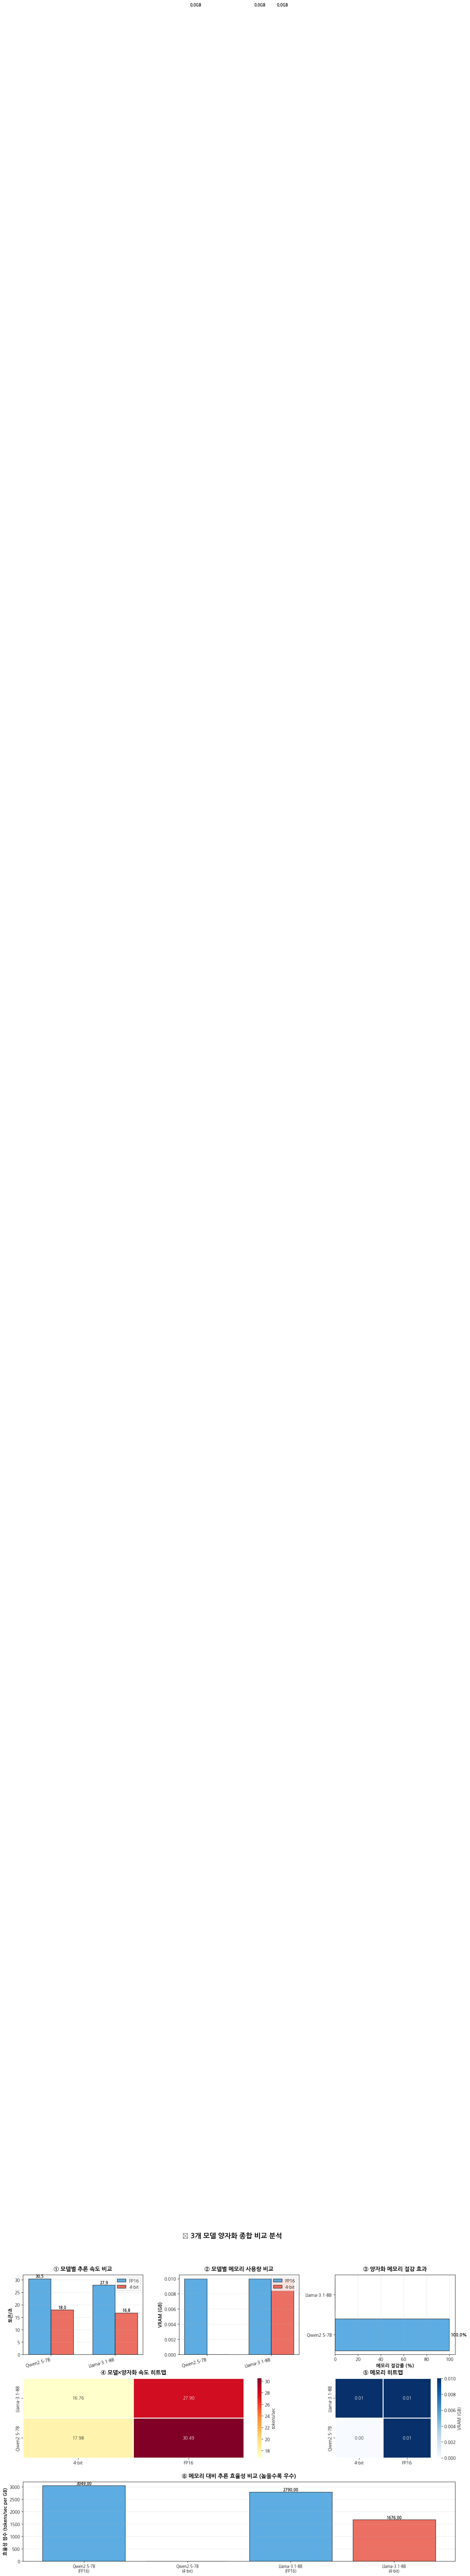


✅ 시각화 완료! 파일 저장: model_quantization_comparison.png

📋 상세 분석 리포트

【 Qwen2.5-7B 】
  • FP16:  30.49 tokens/sec, 0.01 GB VRAM
  • 4-bit: 17.98 tokens/sec, 0.00 GB VRAM
  • 속도 변화: -41.0%
  • 메모리 절감: 100.0%
  💡 권장: 메모리 제약 시 4-bit, 속도 우선 시 FP16

【 Llama-3.1-8B 】
  • FP16:  27.90 tokens/sec, 0.01 GB VRAM
  • 4-bit: 16.76 tokens/sec, 0.01 GB VRAM
  • 속도 변화: -39.9%
  • 메모리 절감: 0.0%
  ⚠️  참고: 양자화 효과 확인 필요

🖥️  GPU 정보
GPU 모델: NVIDIA A100-SXM4-40GB
총 VRAM: 39.56 GB
현재 사용 중: 13.69 GB

✅ 전체 벤치마크 완료!


In [27]:
# ========================================
# 7. 결과 데이터프레임 생성
# ========================================
summary_data = []

for result in all_results:
    summary_data.append({
        '모델': result['model_name'],
        '양자화': result['quantization'],
        '평균 속도 (tokens/sec)': round(result['avg_tokens_per_sec'], 2),
        'VRAM (GB)': round(result['memory_gb'], 2),
        'VRAM (MB)': result['memory_mb']
    })

df_summary = pd.DataFrame(summary_data)

print("\n📊 벤치마크 요약 결과:")
print(df_summary.to_string(index=False))

# ========================================
# 8. 고급 시각화 (6개 그래프)
# ========================================
print("\n📈 시각화 생성 중...")

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 색상 팔레트
colors_models = ['#3498db', '#e74c3c', '#2ecc71']
colors_quant = {'FP16': '#3498db', '4-bit': '#e74c3c'}

# ----------------------------------------
# 그래프 1: 모델별 속도 비교 (그룹 막대)
# ----------------------------------------
ax1 = fig.add_subplot(gs[0, 0])

models = df_summary['모델'].unique()
x = np.arange(len(models))
width = 0.35

fp16_speeds = [df_summary[(df_summary['모델']==m) & (df_summary['양자화']=='FP16')]['평균 속도 (tokens/sec)'].values[0]
               if len(df_summary[(df_summary['모델']==m) & (df_summary['양자화']=='FP16')]) > 0 else 0
               for m in models]
bit4_speeds = [df_summary[(df_summary['모델']==m) & (df_summary['양자화']=='4-bit')]['평균 속도 (tokens/sec)'].values[0]
               if len(df_summary[(df_summary['모델']==m) & (df_summary['양자화']=='4-bit')]) > 0 else 0
               for m in models]

ax1.bar(x - width/2, fp16_speeds, width, label='FP16', color='#3498db', alpha=0.8, edgecolor='black')
ax1.bar(x + width/2, bit4_speeds, width, label='4-bit', color='#e74c3c', alpha=0.8, edgecolor='black')

ax1.set_ylabel('토큰/초', fontsize=11, fontweight='bold')
ax1.set_title('① 모델별 추론 속도 비교', fontsize=13, fontweight='bold', pad=10)
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=15, ha='right')
ax1.legend(loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# 값 표시
for i, (v1, v2) in enumerate(zip(fp16_speeds, bit4_speeds)):
    if v1 > 0:
        ax1.text(i - width/2, v1 + 0.5, f'{v1:.1f}', ha='center', fontsize=9, fontweight='bold')
    if v2 > 0:
        ax1.text(i + width/2, v2 + 0.5, f'{v2:.1f}', ha='center', fontsize=9, fontweight='bold')

# ----------------------------------------
# 그래프 2: 모델별 메모리 사용량 비교
# ----------------------------------------
ax2 = fig.add_subplot(gs[0, 1])

fp16_memory = [df_summary[(df_summary['모델']==m) & (df_summary['양자화']=='FP16')]['VRAM (GB)'].values[0]
               if len(df_summary[(df_summary['모델']==m) & (df_summary['양자화']=='FP16')]) > 0 else 0
               for m in models]
bit4_memory = [df_summary[(df_summary['모델']==m) & (df_summary['양자화']=='4-bit')]['VRAM (GB)'].values[0]
               if len(df_summary[(df_summary['모델']==m) & (df_summary['양자화']=='4-bit')]) > 0 else 0
               for m in models]

ax2.bar(x - width/2, fp16_memory, width, label='FP16', color='#3498db', alpha=0.8, edgecolor='black')
ax2.bar(x + width/2, bit4_memory, width, label='4-bit', color='#e74c3c', alpha=0.8, edgecolor='black')

ax2.set_ylabel('VRAM (GB)', fontsize=11, fontweight='bold')
ax2.set_title('② 모델별 메모리 사용량 비교', fontsize=13, fontweight='bold', pad=10)
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=15, ha='right')
ax2.legend(loc='upper right')
ax2.grid(axis='y', alpha=0.3)

# 값 표시
for i, (v1, v2) in enumerate(zip(fp16_memory, bit4_memory)):
    if v1 > 0:
        ax2.text(i - width/2, v1 + 0.3, f'{v1:.1f}GB', ha='center', fontsize=9, fontweight='bold')
    if v2 > 0:
        ax2.text(i + width/2, v2 + 0.3, f'{v2:.1f}GB', ha='center', fontsize=9, fontweight='bold')

# ----------------------------------------
# 그래프 3: 메모리 절감률 (%)
# ----------------------------------------
ax3 = fig.add_subplot(gs[0, 2])

memory_savings = []
for m in models:
    fp16_mem = df_summary[(df_summary['모델']==m) & (df_summary['양자화']=='FP16')]['VRAM (GB)'].values
    bit4_mem = df_summary[(df_summary['모델']==m) & (df_summary['양자화']=='4-bit')]['VRAM (GB)'].values

    if len(fp16_mem) > 0 and len(bit4_mem) > 0 and fp16_mem[0] > 0:
        saving = (1 - bit4_mem[0] / fp16_mem[0]) * 100
        memory_savings.append(saving)
    else:
        memory_savings.append(0)

bars = ax3.barh(models, memory_savings, color=colors_models, alpha=0.8, edgecolor='black')
ax3.set_xlabel('메모리 절감률 (%)', fontsize=11, fontweight='bold')
ax3.set_title('③ 양자화 메모리 절감 효과', fontsize=13, fontweight='bold', pad=10)
ax3.grid(axis='x', alpha=0.3)

# 값 표시
for i, (bar, v) in enumerate(zip(bars, memory_savings)):
    if v > 0:
        ax3.text(v + 1, i, f'{v:.1f}%', va='center', fontsize=10, fontweight='bold')

# ----------------------------------------
# 그래프 4: Heatmap - 속도 비교
# ----------------------------------------
ax4 = fig.add_subplot(gs[1, :2])

# 피벗 테이블 생성
pivot_speed = df_summary.pivot(index='모델', columns='양자화', values='평균 속도 (tokens/sec)')

sns.heatmap(pivot_speed, annot=True, fmt='.2f', cmap='YlOrRd',
            cbar_kws={'label': 'tokens/sec'}, ax=ax4,
            linewidths=2, linecolor='white')
ax4.set_title('④ 모델×양자화 속도 히트맵', fontsize=13, fontweight='bold', pad=10)
ax4.set_xlabel('')
ax4.set_ylabel('')

# ----------------------------------------
# 그래프 5: Heatmap - 메모리 비교
# ----------------------------------------
ax5 = fig.add_subplot(gs[1, 2])

pivot_memory = df_summary.pivot(index='모델', columns='양자화', values='VRAM (GB)')

sns.heatmap(pivot_memory, annot=True, fmt='.2f', cmap='Blues',
            cbar_kws={'label': 'VRAM (GB)'}, ax=ax5,
            linewidths=2, linecolor='white')
ax5.set_title('⑤ 메모리 히트맵', fontsize=13, fontweight='bold', pad=10)
ax5.set_xlabel('')
ax5.set_ylabel('')

# ----------------------------------------
# 그래프 6: 효율성 점수 (속도/메모리)
# ----------------------------------------
ax6 = fig.add_subplot(gs[2, :])

efficiency_scores = []
labels = []

for _, row in df_summary.iterrows():
    if row['VRAM (GB)'] > 0:
        # 효율성 점수: 속도 / 메모리 (높을수록 효율적)
        efficiency = row['평균 속도 (tokens/sec)'] / row['VRAM (GB)']
        efficiency_scores.append(efficiency)
        labels.append(f"{row['모델']}\n({row['양자화']})")
    else:
        efficiency_scores.append(0)
        labels.append(f"{row['모델']}\n({row['양자화']})")

x_pos = np.arange(len(labels))
colors_bar = [colors_quant[row['양자화']] for _, row in df_summary.iterrows()]

bars = ax6.bar(x_pos, efficiency_scores, color=colors_bar, alpha=0.8, edgecolor='black')
ax6.set_ylabel('효율성 점수 (tokens/sec per GB)', fontsize=11, fontweight='bold')
ax6.set_title('⑥ 메모리 대비 추론 효율성 비교 (높을수록 우수)', fontsize=13, fontweight='bold', pad=10)
ax6.set_xticks(x_pos)
ax6.set_xticklabels(labels, rotation=0, ha='center', fontsize=9)
ax6.grid(axis='y', alpha=0.3)

# 값 표시
for bar, v in zip(bars, efficiency_scores):
    if v > 0:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{v:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('🔬 3개 모델 양자화 종합 비교 분석',
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('model_quantization_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ 시각화 완료! 파일 저장: model_quantization_comparison.png")

# ========================================
# 9. 상세 분석 리포트 출력
# ========================================
print("\n" + "="*70)
print("📋 상세 분석 리포트")
print("="*70)

for model in models:
    print(f"\n【 {model} 】")

    fp16_data = df_summary[(df_summary['모델']==model) & (df_summary['양자화']=='FP16')]
    bit4_data = df_summary[(df_summary['모델']==model) & (df_summary['양자화']=='4-bit')]

    if len(fp16_data) > 0 and len(bit4_data) > 0:
        fp16_speed = fp16_data['평균 속도 (tokens/sec)'].values[0]
        bit4_speed = bit4_data['평균 속도 (tokens/sec)'].values[0]
        fp16_mem = fp16_data['VRAM (GB)'].values[0]
        bit4_mem = bit4_data['VRAM (GB)'].values[0]

        speed_change = ((bit4_speed / fp16_speed) - 1) * 100 if fp16_speed > 0 else 0
        mem_saving = (1 - bit4_mem / fp16_mem) * 100 if fp16_mem > 0 else 0

        print(f"  • FP16:  {fp16_speed:.2f} tokens/sec, {fp16_mem:.2f} GB VRAM")
        print(f"  • 4-bit: {bit4_speed:.2f} tokens/sec, {bit4_mem:.2f} GB VRAM")
        print(f"  • 속도 변화: {speed_change:+.1f}%")
        print(f"  • 메모리 절감: {mem_saving:.1f}%")

        # 권장사항
        if mem_saving > 70 and speed_change > -10:
            print(f"  ✨ 권장: 4-bit 사용 (큰 메모리 절감, 속도 손실 미미)")
        elif mem_saving > 60:
            print(f"  💡 권장: 메모리 제약 시 4-bit, 속도 우선 시 FP16")
        else:
            print(f"  ⚠️  참고: 양자화 효과 확인 필요")

# ========================================
# 10. GPU 정보 출력
# ========================================
print("\n" + "="*70)
print("🖥️  GPU 정보")
print("="*70)

if torch.cuda.is_available():
    print(f"GPU 모델: {torch.cuda.get_device_name(0)}")
    print(f"총 VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"현재 사용 중: {get_gpu_memory() / 1024:.2f} GB")
else:
    print("GPU를 사용할 수 없습니다.")

print("\n" + "="*70)
print("✅ 전체 벤치마크 완료!")
print("="*70)